# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
####################data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

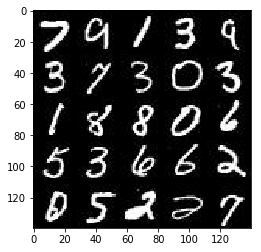

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

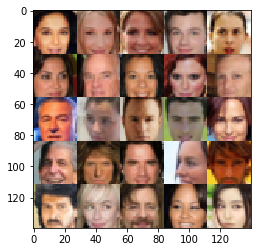

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, lr 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse) :
        # Input layer is 28 X 28 X 3 [32x32x3]
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        x1 = tf.maximum(alpha * x1, x1)
        # 14 X 14 X 64 [16x16x64]
        
        x1 = tf.nn.dropout(x1, 0.5)
        #print("X1:", x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 X 7 X 128 [8x8x128]
        
        x2 = tf.nn.dropout(x2, 0.5)
        #print("X2:", x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4x4x256
        
        x3 = tf.nn.dropout(x3, 0.5)
        #print("X3:", x3.get_shape())

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        #print("OUT SHAPE", tf.shape(out))
        #print("OUT:", out.get_shape())
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #print(tf.shape(z))
    #print("INPUT Z", z.get_shape())
    
    #alpha = 0.01
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train) as scope:
        # Fully connected
        fc1 = tf.layers.dense(z, 7*7*256)
        #fc1 = tf.layers.dense(z, 4*4*256)

        # Reshape
        x1 = tf.reshape(fc1, (-1, 7, 7, 256))
        #x1 = tf.reshape(fc1, (-1, 4, 4, 256))
        
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.nn.relu(x1)
        
        x1 = tf.nn.dropout(x1, 0.5)
        #print("X1:", x1.get_shape())

        # Second layer 
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        
        x2 = tf.nn.dropout(x2, 0.5)
        #print("X2:", x2.get_shape())

        # Ouput layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)
        # (28 x 28 x out_channel_dim)
        
        #print("OUT SHAPE", tf.shape(out))
        #print("OUT:", out.get_shape())

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
            
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
   
    #smooth = 0
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1-smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #print(d_loss)
    #print(g_loss)
    #print(learning_rate)
    #print(beta1)
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    #    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            print("Epoch {}/{}....".format(epoch_i+1, epoch_count))
            batch_i = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #print("Batch {}/{}....".format(batch_i+1, batch_size))
                batch_i += 1
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # the values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.
                # Thus, need to rescale the images to be between -1 and 1 as using tanh in generator function to get logits
                batch_images = batch_images * 2
                
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if batch_i == 1:
                    print("Batch {}/{}....".format(batch_i, batch_size))
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)  
                if batch_i % 10 == 0 :
                    print("Batch {}/{}....".format(batch_i, batch_size))
                if data_image_mode == 'RGB':
                    if batch_i % 600 == 0:
                        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                else:
                    if batch_i % 200 == 0:
                        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)    


            train_loss_d = sess.run(d_loss, {input_z:batch_z, input_real:batch_images})
            train_loss_g = g_loss.eval({input_z:batch_z})
            print("Epoch {}/{}....".format(epoch_i+1, epoch_count), 
                 "Discriminator Loss: {:.4f}....".format(train_loss_d),
                 "Generator Loss: {:.4f}....".format(train_loss_g))
            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
            
            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2....
Batch 1/32....


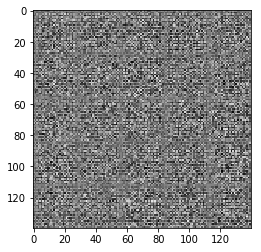

Batch 10/32....
Batch 20/32....
Batch 30/32....
Batch 40/32....
Batch 50/32....
Batch 60/32....
Batch 70/32....
Batch 80/32....
Batch 90/32....
Batch 100/32....
Batch 110/32....
Batch 120/32....
Batch 130/32....
Batch 140/32....
Batch 150/32....
Batch 160/32....
Batch 170/32....
Batch 180/32....
Batch 190/32....
Batch 200/32....


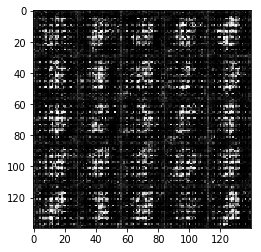

Batch 210/32....
Batch 220/32....
Batch 230/32....
Batch 240/32....
Batch 250/32....
Batch 260/32....
Batch 270/32....
Batch 280/32....
Batch 290/32....
Batch 300/32....
Batch 310/32....
Batch 320/32....
Batch 330/32....
Batch 340/32....
Batch 350/32....
Batch 360/32....
Batch 370/32....
Batch 380/32....
Batch 390/32....
Batch 400/32....


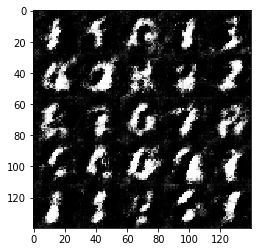

Batch 410/32....
Batch 420/32....
Batch 430/32....
Batch 440/32....
Batch 450/32....
Batch 460/32....
Batch 470/32....
Batch 480/32....
Batch 490/32....
Batch 500/32....
Batch 510/32....
Batch 520/32....
Batch 530/32....
Batch 540/32....
Batch 550/32....
Batch 560/32....
Batch 570/32....
Batch 580/32....
Batch 590/32....
Batch 600/32....


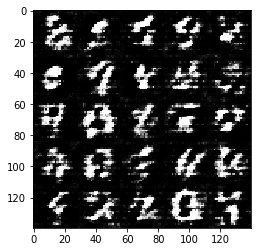

Batch 610/32....
Batch 620/32....
Batch 630/32....
Batch 640/32....
Batch 650/32....
Batch 660/32....
Batch 670/32....
Batch 680/32....
Batch 690/32....
Batch 700/32....
Batch 710/32....
Batch 720/32....
Batch 730/32....
Batch 740/32....
Batch 750/32....
Batch 760/32....
Batch 770/32....
Batch 780/32....
Batch 790/32....
Batch 800/32....


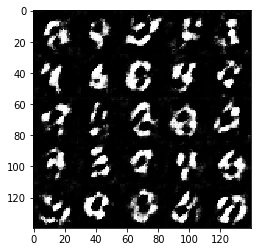

Batch 810/32....
Batch 820/32....
Batch 830/32....
Batch 840/32....
Batch 850/32....
Batch 860/32....
Batch 870/32....
Batch 880/32....
Batch 890/32....
Batch 900/32....
Batch 910/32....
Batch 920/32....
Batch 930/32....
Batch 940/32....
Batch 950/32....
Batch 960/32....
Batch 970/32....
Batch 980/32....
Batch 990/32....
Batch 1000/32....


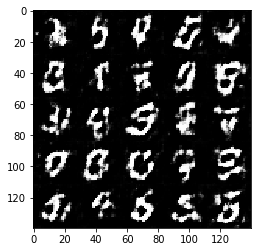

Batch 1010/32....
Batch 1020/32....
Batch 1030/32....
Batch 1040/32....
Batch 1050/32....
Batch 1060/32....
Batch 1070/32....
Batch 1080/32....
Batch 1090/32....
Batch 1100/32....
Batch 1110/32....
Batch 1120/32....
Batch 1130/32....
Batch 1140/32....
Batch 1150/32....
Batch 1160/32....
Batch 1170/32....
Batch 1180/32....
Batch 1190/32....
Batch 1200/32....


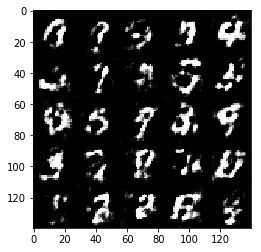

Batch 1210/32....
Batch 1220/32....
Batch 1230/32....
Batch 1240/32....
Batch 1250/32....
Batch 1260/32....
Batch 1270/32....
Batch 1280/32....
Batch 1290/32....
Batch 1300/32....
Batch 1310/32....
Batch 1320/32....
Batch 1330/32....
Batch 1340/32....
Batch 1350/32....
Batch 1360/32....
Batch 1370/32....
Batch 1380/32....
Batch 1390/32....
Batch 1400/32....


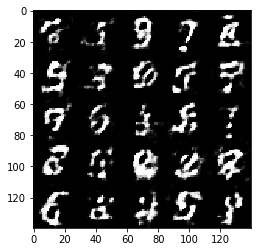

Batch 1410/32....
Batch 1420/32....
Batch 1430/32....
Batch 1440/32....
Batch 1450/32....
Batch 1460/32....
Batch 1470/32....
Batch 1480/32....
Batch 1490/32....
Batch 1500/32....
Batch 1510/32....
Batch 1520/32....
Batch 1530/32....
Batch 1540/32....
Batch 1550/32....
Batch 1560/32....
Batch 1570/32....
Batch 1580/32....
Batch 1590/32....
Batch 1600/32....


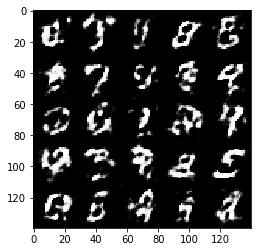

Batch 1610/32....
Batch 1620/32....
Batch 1630/32....
Batch 1640/32....
Batch 1650/32....
Batch 1660/32....
Batch 1670/32....
Batch 1680/32....
Batch 1690/32....
Batch 1700/32....
Batch 1710/32....
Batch 1720/32....
Batch 1730/32....
Batch 1740/32....
Batch 1750/32....
Batch 1760/32....
Batch 1770/32....
Batch 1780/32....
Batch 1790/32....
Batch 1800/32....


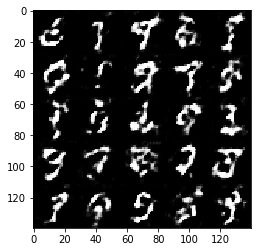

Batch 1810/32....
Batch 1820/32....
Batch 1830/32....
Batch 1840/32....
Batch 1850/32....
Batch 1860/32....
Batch 1870/32....
Epoch 1/2.... Discriminator Loss: 1.1050.... Generator Loss: 2.0848....


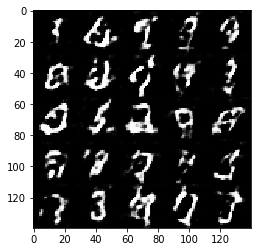

Epoch 2/2....
Batch 1/32....


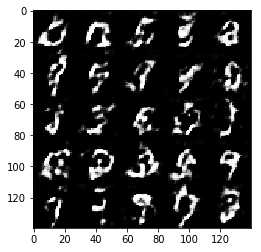

Batch 10/32....
Batch 20/32....
Batch 30/32....
Batch 40/32....
Batch 50/32....
Batch 60/32....
Batch 70/32....
Batch 80/32....
Batch 90/32....
Batch 100/32....
Batch 110/32....
Batch 120/32....
Batch 130/32....
Batch 140/32....
Batch 150/32....
Batch 160/32....
Batch 170/32....
Batch 180/32....
Batch 190/32....
Batch 200/32....


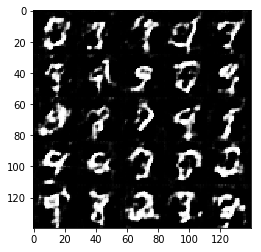

Batch 210/32....
Batch 220/32....
Batch 230/32....
Batch 240/32....
Batch 250/32....
Batch 260/32....
Batch 270/32....
Batch 280/32....
Batch 290/32....
Batch 300/32....
Batch 310/32....
Batch 320/32....
Batch 330/32....
Batch 340/32....
Batch 350/32....
Batch 360/32....
Batch 370/32....
Batch 380/32....
Batch 390/32....
Batch 400/32....


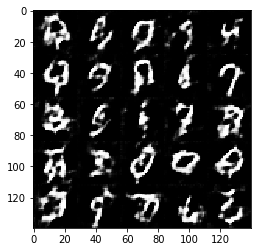

Batch 410/32....
Batch 420/32....
Batch 430/32....
Batch 440/32....
Batch 450/32....
Batch 460/32....
Batch 470/32....
Batch 480/32....
Batch 490/32....
Batch 500/32....
Batch 510/32....
Batch 520/32....
Batch 530/32....
Batch 540/32....
Batch 550/32....
Batch 560/32....
Batch 570/32....
Batch 580/32....
Batch 590/32....
Batch 600/32....


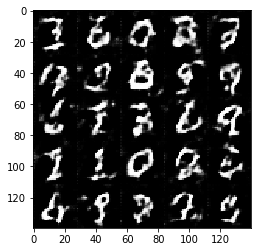

Batch 610/32....
Batch 620/32....
Batch 630/32....
Batch 640/32....
Batch 650/32....
Batch 660/32....
Batch 670/32....
Batch 680/32....
Batch 690/32....
Batch 700/32....
Batch 710/32....
Batch 720/32....
Batch 730/32....
Batch 740/32....
Batch 750/32....
Batch 760/32....
Batch 770/32....
Batch 780/32....
Batch 790/32....
Batch 800/32....


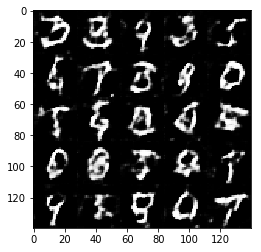

Batch 810/32....
Batch 820/32....
Batch 830/32....
Batch 840/32....
Batch 850/32....
Batch 860/32....
Batch 870/32....
Batch 880/32....
Batch 890/32....
Batch 900/32....
Batch 910/32....
Batch 920/32....
Batch 930/32....
Batch 940/32....
Batch 950/32....
Batch 960/32....
Batch 970/32....
Batch 980/32....
Batch 990/32....
Batch 1000/32....


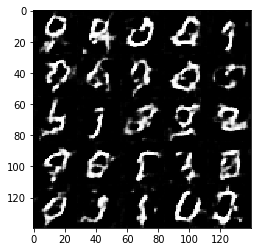

Batch 1010/32....
Batch 1020/32....
Batch 1030/32....
Batch 1040/32....
Batch 1050/32....
Batch 1060/32....
Batch 1070/32....
Batch 1080/32....
Batch 1090/32....
Batch 1100/32....
Batch 1110/32....
Batch 1120/32....
Batch 1130/32....
Batch 1140/32....
Batch 1150/32....
Batch 1160/32....
Batch 1170/32....
Batch 1180/32....
Batch 1190/32....
Batch 1200/32....


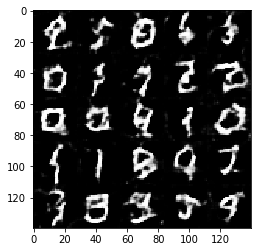

Batch 1210/32....
Batch 1220/32....
Batch 1230/32....
Batch 1240/32....
Batch 1250/32....
Batch 1260/32....
Batch 1270/32....
Batch 1280/32....
Batch 1290/32....
Batch 1300/32....
Batch 1310/32....
Batch 1320/32....
Batch 1330/32....
Batch 1340/32....
Batch 1350/32....
Batch 1360/32....
Batch 1370/32....
Batch 1380/32....
Batch 1390/32....
Batch 1400/32....


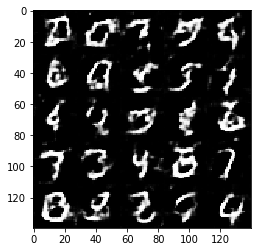

Batch 1410/32....
Batch 1420/32....
Batch 1430/32....
Batch 1440/32....
Batch 1450/32....
Batch 1460/32....
Batch 1470/32....
Batch 1480/32....
Batch 1490/32....
Batch 1500/32....
Batch 1510/32....
Batch 1520/32....
Batch 1530/32....
Batch 1540/32....
Batch 1550/32....
Batch 1560/32....
Batch 1570/32....
Batch 1580/32....
Batch 1590/32....
Batch 1600/32....


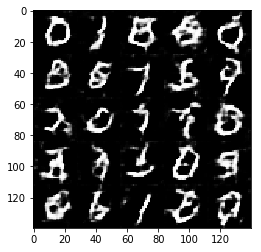

Batch 1610/32....
Batch 1620/32....
Batch 1630/32....
Batch 1640/32....
Batch 1650/32....
Batch 1660/32....
Batch 1670/32....
Batch 1680/32....
Batch 1690/32....
Batch 1700/32....
Batch 1710/32....
Batch 1720/32....
Batch 1730/32....
Batch 1740/32....
Batch 1750/32....
Batch 1760/32....
Batch 1770/32....
Batch 1780/32....
Batch 1790/32....
Batch 1800/32....


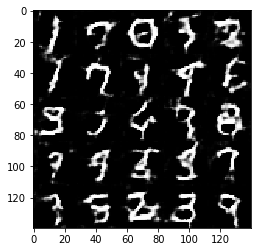

Batch 1810/32....
Batch 1820/32....
Batch 1830/32....
Batch 1840/32....
Batch 1850/32....
Batch 1860/32....
Batch 1870/32....
Epoch 2/2.... Discriminator Loss: 0.7875.... Generator Loss: 1.7022....


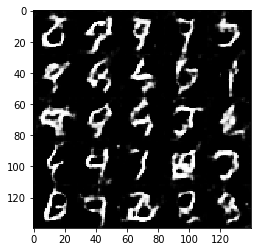

In [12]:
batch_size = 32 # 16 # 128 #512 # 128 #None
z_dim = 100 #32 #None
learning_rate = 0.0001 # 0.0002 #0.002 # 0.01 #None
beta1 = 0.5 #0.1 #None

"""
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5
"""


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1....
Batch 1/16....


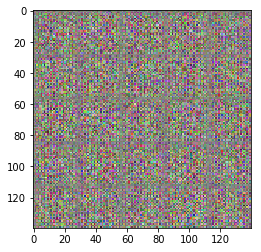

Batch 10/16....
Batch 20/16....
Batch 30/16....
Batch 40/16....
Batch 50/16....
Batch 60/16....
Batch 70/16....
Batch 80/16....
Batch 90/16....
Batch 100/16....
Batch 110/16....
Batch 120/16....
Batch 130/16....
Batch 140/16....
Batch 150/16....
Batch 160/16....
Batch 170/16....
Batch 180/16....
Batch 190/16....
Batch 200/16....
Batch 210/16....
Batch 220/16....
Batch 230/16....
Batch 240/16....
Batch 250/16....
Batch 260/16....
Batch 270/16....
Batch 280/16....
Batch 290/16....
Batch 300/16....
Batch 310/16....
Batch 320/16....
Batch 330/16....
Batch 340/16....
Batch 350/16....
Batch 360/16....
Batch 370/16....
Batch 380/16....
Batch 390/16....
Batch 400/16....
Batch 410/16....
Batch 420/16....
Batch 430/16....
Batch 440/16....
Batch 450/16....
Batch 460/16....
Batch 470/16....
Batch 480/16....
Batch 490/16....
Batch 500/16....
Batch 510/16....
Batch 520/16....
Batch 530/16....
Batch 540/16....
Batch 550/16....
Batch 560/16....
Batch 570/16....
Batch 580/16....
Batch 590/16....
Batch 

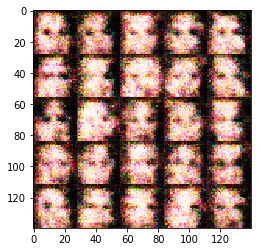

Batch 610/16....
Batch 620/16....
Batch 630/16....
Batch 640/16....
Batch 650/16....
Batch 660/16....
Batch 670/16....
Batch 680/16....
Batch 690/16....
Batch 700/16....
Batch 710/16....
Batch 720/16....
Batch 730/16....
Batch 740/16....
Batch 750/16....
Batch 760/16....
Batch 770/16....
Batch 780/16....
Batch 790/16....
Batch 800/16....
Batch 810/16....
Batch 820/16....
Batch 830/16....
Batch 840/16....
Batch 850/16....
Batch 860/16....
Batch 870/16....
Batch 880/16....
Batch 890/16....
Batch 900/16....
Batch 910/16....
Batch 920/16....
Batch 930/16....
Batch 940/16....
Batch 950/16....
Batch 960/16....
Batch 970/16....
Batch 980/16....
Batch 990/16....
Batch 1000/16....
Batch 1010/16....
Batch 1020/16....
Batch 1030/16....
Batch 1040/16....
Batch 1050/16....
Batch 1060/16....
Batch 1070/16....
Batch 1080/16....
Batch 1090/16....
Batch 1100/16....
Batch 1110/16....
Batch 1120/16....
Batch 1130/16....
Batch 1140/16....
Batch 1150/16....
Batch 1160/16....
Batch 1170/16....
Batch 1180/16

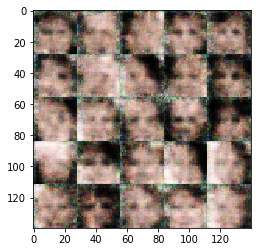

Batch 1210/16....
Batch 1220/16....
Batch 1230/16....
Batch 1240/16....
Batch 1250/16....
Batch 1260/16....
Batch 1270/16....
Batch 1280/16....
Batch 1290/16....
Batch 1300/16....
Batch 1310/16....
Batch 1320/16....
Batch 1330/16....
Batch 1340/16....
Batch 1350/16....
Batch 1360/16....
Batch 1370/16....
Batch 1380/16....
Batch 1390/16....
Batch 1400/16....
Batch 1410/16....
Batch 1420/16....
Batch 1430/16....
Batch 1440/16....
Batch 1450/16....
Batch 1460/16....
Batch 1470/16....
Batch 1480/16....
Batch 1490/16....
Batch 1500/16....
Batch 1510/16....
Batch 1520/16....
Batch 1530/16....
Batch 1540/16....
Batch 1550/16....
Batch 1560/16....
Batch 1570/16....
Batch 1580/16....
Batch 1590/16....
Batch 1600/16....
Batch 1610/16....
Batch 1620/16....
Batch 1630/16....
Batch 1640/16....
Batch 1650/16....
Batch 1660/16....
Batch 1670/16....
Batch 1680/16....
Batch 1690/16....
Batch 1700/16....
Batch 1710/16....
Batch 1720/16....
Batch 1730/16....
Batch 1740/16....
Batch 1750/16....
Batch 1760

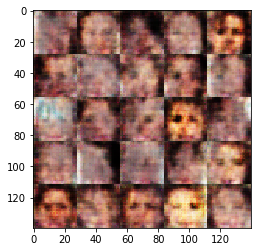

Batch 1810/16....
Batch 1820/16....
Batch 1830/16....
Batch 1840/16....
Batch 1850/16....
Batch 1860/16....
Batch 1870/16....
Batch 1880/16....
Batch 1890/16....
Batch 1900/16....
Batch 1910/16....
Batch 1920/16....
Batch 1930/16....
Batch 1940/16....
Batch 1950/16....
Batch 1960/16....
Batch 1970/16....
Batch 1980/16....
Batch 1990/16....
Batch 2000/16....
Batch 2010/16....
Batch 2020/16....
Batch 2030/16....
Batch 2040/16....
Batch 2050/16....
Batch 2060/16....
Batch 2070/16....
Batch 2080/16....
Batch 2090/16....
Batch 2100/16....
Batch 2110/16....
Batch 2120/16....
Batch 2130/16....
Batch 2140/16....
Batch 2150/16....
Batch 2160/16....
Batch 2170/16....
Batch 2180/16....
Batch 2190/16....
Batch 2200/16....
Batch 2210/16....
Batch 2220/16....
Batch 2230/16....
Batch 2240/16....
Batch 2250/16....
Batch 2260/16....
Batch 2270/16....
Batch 2280/16....
Batch 2290/16....
Batch 2300/16....
Batch 2310/16....
Batch 2320/16....
Batch 2330/16....
Batch 2340/16....
Batch 2350/16....
Batch 2360

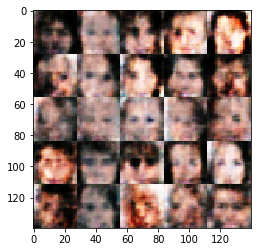

Batch 2410/16....
Batch 2420/16....
Batch 2430/16....
Batch 2440/16....
Batch 2450/16....
Batch 2460/16....
Batch 2470/16....
Batch 2480/16....
Batch 2490/16....
Batch 2500/16....
Batch 2510/16....
Batch 2520/16....
Batch 2530/16....
Batch 2540/16....
Batch 2550/16....
Batch 2560/16....
Batch 2570/16....
Batch 2580/16....
Batch 2590/16....
Batch 2600/16....
Batch 2610/16....
Batch 2620/16....
Batch 2630/16....
Batch 2640/16....
Batch 2650/16....
Batch 2660/16....
Batch 2670/16....
Batch 2680/16....
Batch 2690/16....
Batch 2700/16....
Batch 2710/16....
Batch 2720/16....
Batch 2730/16....
Batch 2740/16....
Batch 2750/16....
Batch 2760/16....
Batch 2770/16....
Batch 2780/16....
Batch 2790/16....
Batch 2800/16....
Batch 2810/16....
Batch 2820/16....
Batch 2830/16....
Batch 2840/16....
Batch 2850/16....
Batch 2860/16....
Batch 2870/16....
Batch 2880/16....
Batch 2890/16....
Batch 2900/16....
Batch 2910/16....
Batch 2920/16....
Batch 2930/16....
Batch 2940/16....
Batch 2950/16....
Batch 2960

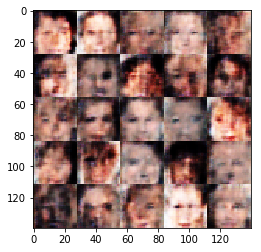

Batch 3010/16....
Batch 3020/16....
Batch 3030/16....
Batch 3040/16....
Batch 3050/16....
Batch 3060/16....
Batch 3070/16....
Batch 3080/16....
Batch 3090/16....
Batch 3100/16....
Batch 3110/16....
Batch 3120/16....
Batch 3130/16....
Batch 3140/16....
Batch 3150/16....
Batch 3160/16....
Batch 3170/16....
Batch 3180/16....
Batch 3190/16....
Batch 3200/16....
Batch 3210/16....
Batch 3220/16....
Batch 3230/16....
Batch 3240/16....
Batch 3250/16....
Batch 3260/16....
Batch 3270/16....
Batch 3280/16....
Batch 3290/16....
Batch 3300/16....
Batch 3310/16....
Batch 3320/16....
Batch 3330/16....
Batch 3340/16....
Batch 3350/16....
Batch 3360/16....
Batch 3370/16....
Batch 3380/16....
Batch 3390/16....
Batch 3400/16....
Batch 3410/16....
Batch 3420/16....
Batch 3430/16....
Batch 3440/16....
Batch 3450/16....
Batch 3460/16....
Batch 3470/16....
Batch 3480/16....
Batch 3490/16....
Batch 3500/16....
Batch 3510/16....
Batch 3520/16....
Batch 3530/16....
Batch 3540/16....
Batch 3550/16....
Batch 3560

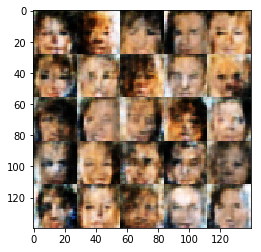

Batch 3610/16....
Batch 3620/16....
Batch 3630/16....
Batch 3640/16....
Batch 3650/16....
Batch 3660/16....
Batch 3670/16....
Batch 3680/16....
Batch 3690/16....
Batch 3700/16....
Batch 3710/16....
Batch 3720/16....
Batch 3730/16....
Batch 3740/16....
Batch 3750/16....
Batch 3760/16....
Batch 3770/16....
Batch 3780/16....
Batch 3790/16....
Batch 3800/16....
Batch 3810/16....
Batch 3820/16....
Batch 3830/16....
Batch 3840/16....
Batch 3850/16....
Batch 3860/16....
Batch 3870/16....
Batch 3880/16....
Batch 3890/16....
Batch 3900/16....
Batch 3910/16....
Batch 3920/16....
Batch 3930/16....
Batch 3940/16....
Batch 3950/16....
Batch 3960/16....
Batch 3970/16....
Batch 3980/16....
Batch 3990/16....
Batch 4000/16....
Batch 4010/16....
Batch 4020/16....
Batch 4030/16....
Batch 4040/16....
Batch 4050/16....
Batch 4060/16....
Batch 4070/16....
Batch 4080/16....
Batch 4090/16....
Batch 4100/16....
Batch 4110/16....
Batch 4120/16....
Batch 4130/16....
Batch 4140/16....
Batch 4150/16....
Batch 4160

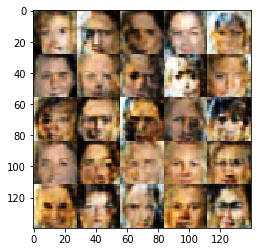

Batch 4210/16....
Batch 4220/16....
Batch 4230/16....
Batch 4240/16....
Batch 4250/16....
Batch 4260/16....
Batch 4270/16....
Batch 4280/16....
Batch 4290/16....
Batch 4300/16....
Batch 4310/16....
Batch 4320/16....
Batch 4330/16....
Batch 4340/16....
Batch 4350/16....
Batch 4360/16....
Batch 4370/16....
Batch 4380/16....
Batch 4390/16....
Batch 4400/16....
Batch 4410/16....
Batch 4420/16....
Batch 4430/16....
Batch 4440/16....
Batch 4450/16....
Batch 4460/16....
Batch 4470/16....
Batch 4480/16....
Batch 4490/16....
Batch 4500/16....
Batch 4510/16....
Batch 4520/16....
Batch 4530/16....
Batch 4540/16....
Batch 4550/16....
Batch 4560/16....
Batch 4570/16....
Batch 4580/16....
Batch 4590/16....
Batch 4600/16....
Batch 4610/16....
Batch 4620/16....
Batch 4630/16....
Batch 4640/16....
Batch 4650/16....
Batch 4660/16....
Batch 4670/16....
Batch 4680/16....
Batch 4690/16....
Batch 4700/16....
Batch 4710/16....
Batch 4720/16....
Batch 4730/16....
Batch 4740/16....
Batch 4750/16....
Batch 4760

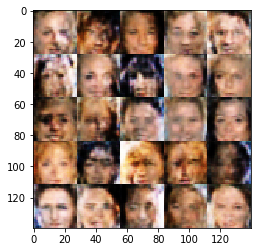

Batch 4810/16....
Batch 4820/16....
Batch 4830/16....
Batch 4840/16....
Batch 4850/16....
Batch 4860/16....
Batch 4870/16....
Batch 4880/16....
Batch 4890/16....
Batch 4900/16....
Batch 4910/16....
Batch 4920/16....
Batch 4930/16....
Batch 4940/16....
Batch 4950/16....
Batch 4960/16....
Batch 4970/16....
Batch 4980/16....
Batch 4990/16....
Batch 5000/16....
Batch 5010/16....
Batch 5020/16....
Batch 5030/16....
Batch 5040/16....
Batch 5050/16....
Batch 5060/16....
Batch 5070/16....
Batch 5080/16....
Batch 5090/16....
Batch 5100/16....
Batch 5110/16....
Batch 5120/16....
Batch 5130/16....
Batch 5140/16....
Batch 5150/16....
Batch 5160/16....
Batch 5170/16....
Batch 5180/16....
Batch 5190/16....
Batch 5200/16....
Batch 5210/16....
Batch 5220/16....
Batch 5230/16....
Batch 5240/16....
Batch 5250/16....
Batch 5260/16....
Batch 5270/16....
Batch 5280/16....
Batch 5290/16....
Batch 5300/16....
Batch 5310/16....
Batch 5320/16....
Batch 5330/16....
Batch 5340/16....
Batch 5350/16....
Batch 5360

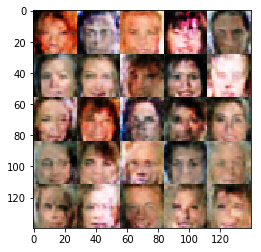

Batch 5410/16....
Batch 5420/16....
Batch 5430/16....
Batch 5440/16....
Batch 5450/16....
Batch 5460/16....
Batch 5470/16....
Batch 5480/16....
Batch 5490/16....
Batch 5500/16....
Batch 5510/16....
Batch 5520/16....
Batch 5530/16....
Batch 5540/16....
Batch 5550/16....
Batch 5560/16....
Batch 5570/16....
Batch 5580/16....
Batch 5590/16....
Batch 5600/16....
Batch 5610/16....
Batch 5620/16....
Batch 5630/16....
Batch 5640/16....
Batch 5650/16....
Batch 5660/16....
Batch 5670/16....
Batch 5680/16....
Batch 5690/16....
Batch 5700/16....
Batch 5710/16....
Batch 5720/16....
Batch 5730/16....
Batch 5740/16....
Batch 5750/16....
Batch 5760/16....
Batch 5770/16....
Batch 5780/16....
Batch 5790/16....
Batch 5800/16....
Batch 5810/16....
Batch 5820/16....
Batch 5830/16....
Batch 5840/16....
Batch 5850/16....
Batch 5860/16....
Batch 5870/16....
Batch 5880/16....
Batch 5890/16....
Batch 5900/16....
Batch 5910/16....
Batch 5920/16....
Batch 5930/16....
Batch 5940/16....
Batch 5950/16....
Batch 5960

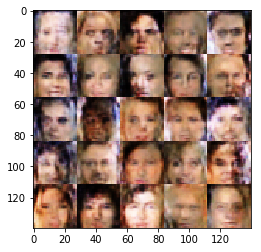

Batch 6010/16....
Batch 6020/16....
Batch 6030/16....
Batch 6040/16....
Batch 6050/16....
Batch 6060/16....
Batch 6070/16....
Batch 6080/16....
Batch 6090/16....
Batch 6100/16....
Batch 6110/16....
Batch 6120/16....
Batch 6130/16....
Batch 6140/16....
Batch 6150/16....
Batch 6160/16....
Batch 6170/16....
Batch 6180/16....
Batch 6190/16....
Batch 6200/16....
Batch 6210/16....
Batch 6220/16....
Batch 6230/16....
Batch 6240/16....
Batch 6250/16....
Batch 6260/16....
Batch 6270/16....
Batch 6280/16....
Batch 6290/16....
Batch 6300/16....
Batch 6310/16....
Batch 6320/16....
Batch 6330/16....
Batch 6340/16....
Batch 6350/16....
Batch 6360/16....
Batch 6370/16....
Batch 6380/16....
Batch 6390/16....
Batch 6400/16....
Batch 6410/16....
Batch 6420/16....
Batch 6430/16....
Batch 6440/16....
Batch 6450/16....
Batch 6460/16....
Batch 6470/16....
Batch 6480/16....
Batch 6490/16....
Batch 6500/16....
Batch 6510/16....
Batch 6520/16....
Batch 6530/16....
Batch 6540/16....
Batch 6550/16....
Batch 6560

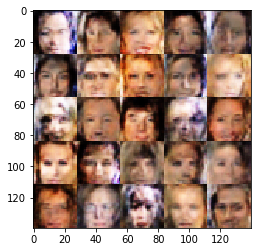

Batch 6610/16....
Batch 6620/16....
Batch 6630/16....
Batch 6640/16....
Batch 6650/16....
Batch 6660/16....
Batch 6670/16....
Batch 6680/16....
Batch 6690/16....
Batch 6700/16....
Batch 6710/16....
Batch 6720/16....
Batch 6730/16....
Batch 6740/16....
Batch 6750/16....
Batch 6760/16....
Batch 6770/16....
Batch 6780/16....
Batch 6790/16....
Batch 6800/16....
Batch 6810/16....
Batch 6820/16....
Batch 6830/16....
Batch 6840/16....
Batch 6850/16....
Batch 6860/16....
Batch 6870/16....
Batch 6880/16....
Batch 6890/16....
Batch 6900/16....
Batch 6910/16....
Batch 6920/16....
Batch 6930/16....
Batch 6940/16....
Batch 6950/16....
Batch 6960/16....
Batch 6970/16....
Batch 6980/16....
Batch 6990/16....
Batch 7000/16....
Batch 7010/16....
Batch 7020/16....
Batch 7030/16....
Batch 7040/16....
Batch 7050/16....
Batch 7060/16....
Batch 7070/16....
Batch 7080/16....
Batch 7090/16....
Batch 7100/16....
Batch 7110/16....
Batch 7120/16....
Batch 7130/16....
Batch 7140/16....
Batch 7150/16....
Batch 7160

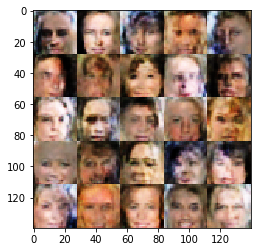

Batch 7210/16....
Batch 7220/16....
Batch 7230/16....
Batch 7240/16....
Batch 7250/16....
Batch 7260/16....
Batch 7270/16....
Batch 7280/16....
Batch 7290/16....
Batch 7300/16....
Batch 7310/16....
Batch 7320/16....
Batch 7330/16....
Batch 7340/16....
Batch 7350/16....
Batch 7360/16....
Batch 7370/16....
Batch 7380/16....
Batch 7390/16....
Batch 7400/16....
Batch 7410/16....
Batch 7420/16....
Batch 7430/16....
Batch 7440/16....
Batch 7450/16....
Batch 7460/16....
Batch 7470/16....
Batch 7480/16....
Batch 7490/16....
Batch 7500/16....
Batch 7510/16....
Batch 7520/16....
Batch 7530/16....
Batch 7540/16....
Batch 7550/16....
Batch 7560/16....
Batch 7570/16....
Batch 7580/16....
Batch 7590/16....
Batch 7600/16....
Batch 7610/16....
Batch 7620/16....
Batch 7630/16....
Batch 7640/16....
Batch 7650/16....
Batch 7660/16....
Batch 7670/16....
Batch 7680/16....
Batch 7690/16....
Batch 7700/16....
Batch 7710/16....
Batch 7720/16....
Batch 7730/16....
Batch 7740/16....
Batch 7750/16....
Batch 7760

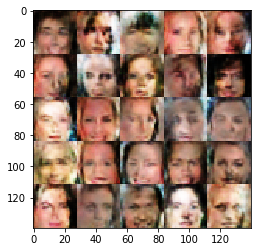

Batch 7810/16....
Batch 7820/16....
Batch 7830/16....
Batch 7840/16....
Batch 7850/16....
Batch 7860/16....
Batch 7870/16....
Batch 7880/16....
Batch 7890/16....
Batch 7900/16....
Batch 7910/16....
Batch 7920/16....
Batch 7930/16....
Batch 7940/16....
Batch 7950/16....
Batch 7960/16....
Batch 7970/16....
Batch 7980/16....
Batch 7990/16....
Batch 8000/16....
Batch 8010/16....
Batch 8020/16....
Batch 8030/16....
Batch 8040/16....
Batch 8050/16....
Batch 8060/16....
Batch 8070/16....
Batch 8080/16....
Batch 8090/16....
Batch 8100/16....
Batch 8110/16....
Batch 8120/16....
Batch 8130/16....
Batch 8140/16....
Batch 8150/16....
Batch 8160/16....
Batch 8170/16....
Batch 8180/16....
Batch 8190/16....
Batch 8200/16....
Batch 8210/16....
Batch 8220/16....
Batch 8230/16....
Batch 8240/16....
Batch 8250/16....
Batch 8260/16....
Batch 8270/16....
Batch 8280/16....
Batch 8290/16....
Batch 8300/16....
Batch 8310/16....
Batch 8320/16....
Batch 8330/16....
Batch 8340/16....
Batch 8350/16....
Batch 8360

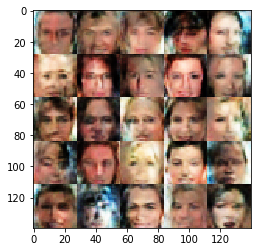

Batch 8410/16....
Batch 8420/16....
Batch 8430/16....
Batch 8440/16....
Batch 8450/16....
Batch 8460/16....
Batch 8470/16....
Batch 8480/16....
Batch 8490/16....
Batch 8500/16....
Batch 8510/16....
Batch 8520/16....
Batch 8530/16....
Batch 8540/16....
Batch 8550/16....
Batch 8560/16....
Batch 8570/16....
Batch 8580/16....
Batch 8590/16....
Batch 8600/16....
Batch 8610/16....
Batch 8620/16....
Batch 8630/16....
Batch 8640/16....
Batch 8650/16....
Batch 8660/16....
Batch 8670/16....
Batch 8680/16....
Batch 8690/16....
Batch 8700/16....
Batch 8710/16....
Batch 8720/16....
Batch 8730/16....
Batch 8740/16....
Batch 8750/16....
Batch 8760/16....
Batch 8770/16....
Batch 8780/16....
Batch 8790/16....
Batch 8800/16....
Batch 8810/16....
Batch 8820/16....
Batch 8830/16....
Batch 8840/16....
Batch 8850/16....
Batch 8860/16....
Batch 8870/16....
Batch 8880/16....
Batch 8890/16....
Batch 8900/16....
Batch 8910/16....
Batch 8920/16....
Batch 8930/16....
Batch 8940/16....
Batch 8950/16....
Batch 8960

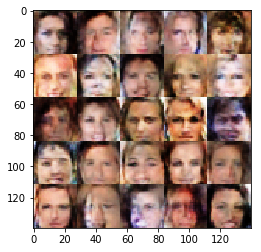

Batch 9010/16....
Batch 9020/16....
Batch 9030/16....
Batch 9040/16....
Batch 9050/16....
Batch 9060/16....
Batch 9070/16....
Batch 9080/16....
Batch 9090/16....
Batch 9100/16....
Batch 9110/16....
Batch 9120/16....
Batch 9130/16....
Batch 9140/16....
Batch 9150/16....
Batch 9160/16....
Batch 9170/16....
Batch 9180/16....
Batch 9190/16....
Batch 9200/16....
Batch 9210/16....
Batch 9220/16....
Batch 9230/16....
Batch 9240/16....
Batch 9250/16....
Batch 9260/16....
Batch 9270/16....
Batch 9280/16....
Batch 9290/16....
Batch 9300/16....
Batch 9310/16....
Batch 9320/16....
Batch 9330/16....
Batch 9340/16....
Batch 9350/16....
Batch 9360/16....
Batch 9370/16....
Batch 9380/16....
Batch 9390/16....
Batch 9400/16....
Batch 9410/16....
Batch 9420/16....
Batch 9430/16....
Batch 9440/16....
Batch 9450/16....
Batch 9460/16....
Batch 9470/16....
Batch 9480/16....
Batch 9490/16....
Batch 9500/16....
Batch 9510/16....
Batch 9520/16....
Batch 9530/16....
Batch 9540/16....
Batch 9550/16....
Batch 9560

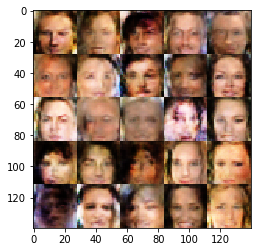

Batch 9610/16....
Batch 9620/16....
Batch 9630/16....
Batch 9640/16....
Batch 9650/16....
Batch 9660/16....
Batch 9670/16....
Batch 9680/16....
Batch 9690/16....
Batch 9700/16....
Batch 9710/16....
Batch 9720/16....
Batch 9730/16....
Batch 9740/16....
Batch 9750/16....
Batch 9760/16....
Batch 9770/16....
Batch 9780/16....
Batch 9790/16....
Batch 9800/16....
Batch 9810/16....
Batch 9820/16....
Batch 9830/16....
Batch 9840/16....
Batch 9850/16....
Batch 9860/16....
Batch 9870/16....
Batch 9880/16....
Batch 9890/16....
Batch 9900/16....
Batch 9910/16....
Batch 9920/16....
Batch 9930/16....
Batch 9940/16....
Batch 9950/16....
Batch 9960/16....
Batch 9970/16....
Batch 9980/16....
Batch 9990/16....
Batch 10000/16....
Batch 10010/16....
Batch 10020/16....
Batch 10030/16....
Batch 10040/16....
Batch 10050/16....
Batch 10060/16....
Batch 10070/16....
Batch 10080/16....
Batch 10090/16....
Batch 10100/16....
Batch 10110/16....
Batch 10120/16....
Batch 10130/16....
Batch 10140/16....
Batch 10150/1

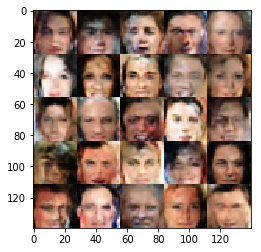

Batch 10210/16....
Batch 10220/16....
Batch 10230/16....
Batch 10240/16....
Batch 10250/16....
Batch 10260/16....
Batch 10270/16....
Batch 10280/16....
Batch 10290/16....
Batch 10300/16....
Batch 10310/16....
Batch 10320/16....
Batch 10330/16....
Batch 10340/16....
Batch 10350/16....
Batch 10360/16....
Batch 10370/16....
Batch 10380/16....
Batch 10390/16....
Batch 10400/16....
Batch 10410/16....
Batch 10420/16....
Batch 10430/16....
Batch 10440/16....
Batch 10450/16....
Batch 10460/16....
Batch 10470/16....
Batch 10480/16....
Batch 10490/16....
Batch 10500/16....
Batch 10510/16....
Batch 10520/16....
Batch 10530/16....
Batch 10540/16....
Batch 10550/16....
Batch 10560/16....
Batch 10570/16....
Batch 10580/16....
Batch 10590/16....
Batch 10600/16....
Batch 10610/16....
Batch 10620/16....
Batch 10630/16....
Batch 10640/16....
Batch 10650/16....
Batch 10660/16....
Batch 10670/16....
Batch 10680/16....
Batch 10690/16....
Batch 10700/16....
Batch 10710/16....
Batch 10720/16....
Batch 10730/

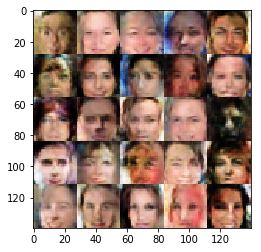

Batch 10810/16....
Batch 10820/16....
Batch 10830/16....
Batch 10840/16....
Batch 10850/16....
Batch 10860/16....
Batch 10870/16....
Batch 10880/16....
Batch 10890/16....
Batch 10900/16....
Batch 10910/16....
Batch 10920/16....
Batch 10930/16....
Batch 10940/16....
Batch 10950/16....
Batch 10960/16....
Batch 10970/16....
Batch 10980/16....
Batch 10990/16....
Batch 11000/16....
Batch 11010/16....
Batch 11020/16....
Batch 11030/16....
Batch 11040/16....
Batch 11050/16....
Batch 11060/16....
Batch 11070/16....
Batch 11080/16....
Batch 11090/16....
Batch 11100/16....
Batch 11110/16....
Batch 11120/16....
Batch 11130/16....
Batch 11140/16....
Batch 11150/16....
Batch 11160/16....
Batch 11170/16....
Batch 11180/16....
Batch 11190/16....
Batch 11200/16....
Batch 11210/16....
Batch 11220/16....
Batch 11230/16....
Batch 11240/16....
Batch 11250/16....
Batch 11260/16....
Batch 11270/16....
Batch 11280/16....
Batch 11290/16....
Batch 11300/16....
Batch 11310/16....
Batch 11320/16....
Batch 11330/

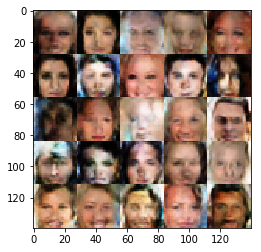

Batch 11410/16....
Batch 11420/16....
Batch 11430/16....
Batch 11440/16....
Batch 11450/16....
Batch 11460/16....
Batch 11470/16....
Batch 11480/16....
Batch 11490/16....
Batch 11500/16....
Batch 11510/16....
Batch 11520/16....
Batch 11530/16....
Batch 11540/16....
Batch 11550/16....
Batch 11560/16....
Batch 11570/16....
Batch 11580/16....
Batch 11590/16....
Batch 11600/16....
Batch 11610/16....
Batch 11620/16....
Batch 11630/16....
Batch 11640/16....
Batch 11650/16....
Batch 11660/16....
Batch 11670/16....
Batch 11680/16....
Batch 11690/16....
Batch 11700/16....
Batch 11710/16....
Batch 11720/16....
Batch 11730/16....
Batch 11740/16....
Batch 11750/16....
Batch 11760/16....
Batch 11770/16....
Batch 11780/16....
Batch 11790/16....
Batch 11800/16....
Batch 11810/16....
Batch 11820/16....
Batch 11830/16....
Batch 11840/16....
Batch 11850/16....
Batch 11860/16....
Batch 11870/16....
Batch 11880/16....
Batch 11890/16....
Batch 11900/16....
Batch 11910/16....
Batch 11920/16....
Batch 11930/

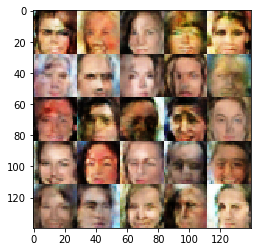

Batch 12010/16....
Batch 12020/16....
Batch 12030/16....
Batch 12040/16....
Batch 12050/16....
Batch 12060/16....
Batch 12070/16....
Batch 12080/16....
Batch 12090/16....
Batch 12100/16....
Batch 12110/16....
Batch 12120/16....
Batch 12130/16....
Batch 12140/16....
Batch 12150/16....
Batch 12160/16....
Batch 12170/16....
Batch 12180/16....
Batch 12190/16....
Batch 12200/16....
Batch 12210/16....
Batch 12220/16....
Batch 12230/16....
Batch 12240/16....
Batch 12250/16....
Batch 12260/16....
Batch 12270/16....
Batch 12280/16....
Batch 12290/16....
Batch 12300/16....
Batch 12310/16....
Batch 12320/16....
Batch 12330/16....
Batch 12340/16....
Batch 12350/16....
Batch 12360/16....
Batch 12370/16....
Batch 12380/16....
Batch 12390/16....
Batch 12400/16....
Batch 12410/16....
Batch 12420/16....
Batch 12430/16....
Batch 12440/16....
Batch 12450/16....
Batch 12460/16....
Batch 12470/16....
Batch 12480/16....
Batch 12490/16....
Batch 12500/16....
Batch 12510/16....
Batch 12520/16....
Batch 12530/

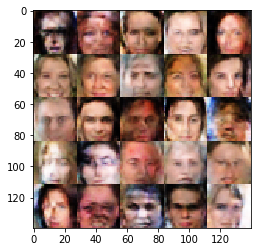

Batch 12610/16....
Batch 12620/16....
Batch 12630/16....
Batch 12640/16....
Batch 12650/16....
Batch 12660/16....
Epoch 1/1.... Discriminator Loss: 1.5300.... Generator Loss: 0.6577....


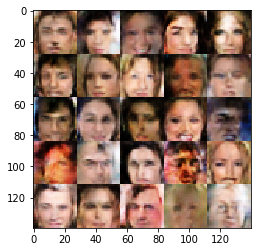

In [23]:
batch_size = 16 # 32 #128 #512 #32 #None
z_dim = 100 #32 #100 #32 #None
learning_rate = 0.0001 # 0.0002 # 0.01 #None
beta1 = 0.5 #0.1 #0.5 #0.1 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.